In [1]:
using DrWatson

In [20]:
using StatsBase, Pipe, ProgressBars, Random
using LinearAlgebra, Distances, Distributions, LaTeXStrings
using Plots, Ripserer, PersistenceDiagrams, PersistenceDiagramsBase

In [21]:
include(srcdir("rdpg.jl"))
import Main.rdpg

### Parameters

In [46]:
n = 1000
d = 1
dim = 3
ϵ = 0.1
theme(:default)

### Latent Positions
----

The latent positions $\mathbb{X}_n \sim \text{unif}(\mathbb{S}^1)$ are sampled uniformly from a circle.

In [47]:
Z = map(x -> x .* 2, rdpg.randCircle(n, s=0.01))
dist_max = pairwise(Euclidean(), Z) |> maximum
f = (x, y) -> dot(x, y)

#23 (generic function with 1 method)

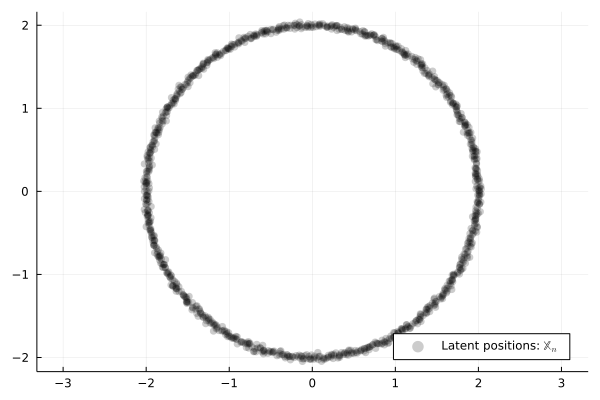

In [50]:
plt0 = @pipe Z |> scatter(_, c=:black, ratio=1, ma=0.2, label="Latent positions: " * L"\mathbb{X}_n", legend=:bottomright)

### Generalized random-dot product graph
----

The generalized random dot-product graph is generated using the latent positions to obtain $A \sim \text{gRDPG}(\mathbb{P}, \mathbb{X}_n)$ and $\widehat{\mathbb X}_n = \mathsf{spectral}(A)$.

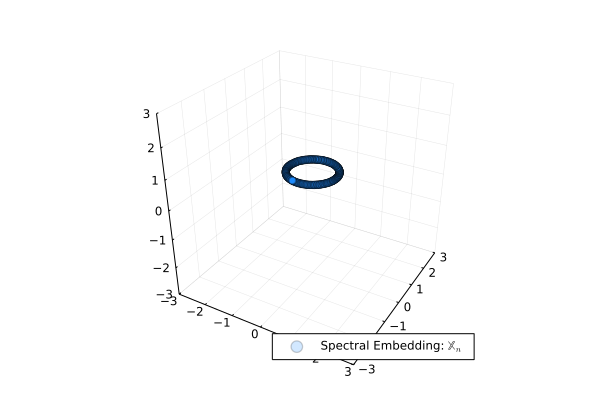

In [59]:
Random.seed!(2022)
A = rdpg.Adjacency(f, Z)
X, _ = rdpg.spectralEmbed(A, d = 3, scale = false)
plt1 = @pipe X |>
                rdpg._Matrix_to_ArrayOfTuples |>
                scatter(_, c = :dodgerblue, ratio = 1, ma=0.2, lim = (-3,3), label="Spectral Embedding: " * L"\mathbb{X}_n", legend=:bottomright)

### $\epsilon-$ differentially private synthetic graph
----

For a choice of $\epsilon$, the $\epsilon-$ DP synthetic graph under edgeFlip is obtained as $B = \mathcal{M}_\epsilon(A)$ and $\widehat{\mathbb Y}_n = \mathsf{spectral}(B)$.

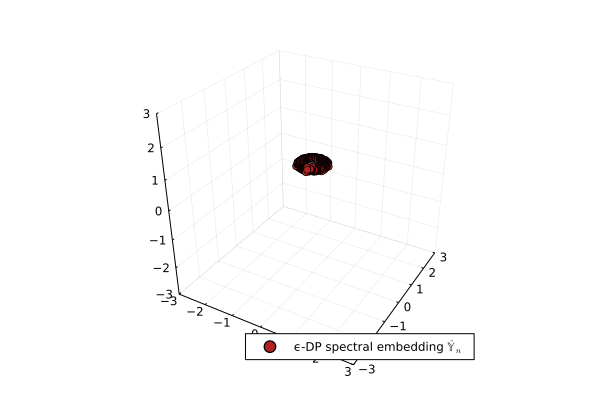

In [58]:
Random.seed!(2022)
B = @pipe A |> rdpg.edgeFlip(_, ϵ=ϵ)
Y, _ = rdpg.spectralEmbed(B, d = 3, scale = false)
plt2 = @pipe Y |> 
               rdpg._Matrix_to_ArrayOfTuples |>
               scatter(_, c = :firebrick, ratio = 1, lim = (-3, 3), label = "ϵ-DP spectral embedding " * L"$\widehat{\mathbb{Y}}_n$", legend = :bottomright)

Although $\widehat{\mathbb{X}}_n$ and $\widehat{\mathbb{Y}}_n$ encode similar information, from Proposition 3.4 we know that they do not belong to the same isometry class. Therefore, they don't have similar persistence diagrams. 

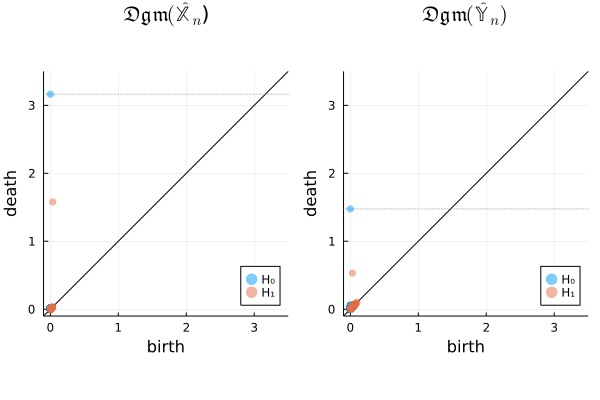

In [54]:
Dx = @pipe X |> rdpg._Matrix_to_ArrayOfTuples |> ripserer(Alpha(_), dim_max = 1)
Dy = @pipe Y |> rdpg._Matrix_to_ArrayOfTuples |> ripserer(Alpha(_), dim_max = 1)
plt = plot(
    plot(Dx, lim=(-0.1, 3.5), ratio=1 , title=L"$\mathfrak{Dgm}(\widehat{\mathbb{X}}_n$)"), 
    plot(Dy, lim=(-0.1, 3.5), ratio=1 , title=L"$\mathfrak{Dgm}(\widehat{\mathbb{Y}}_n)$"));

plt

However, from Proposition 3.5 we know that on a log-scale they should have the same persistence diagrams, i.e. $\log\mathfrak{Dgm}(\widehat{\mathbb{X}}_n) \approx \log\mathfrak{Dgm}(\widehat{\mathbb{Y}}_n)$.

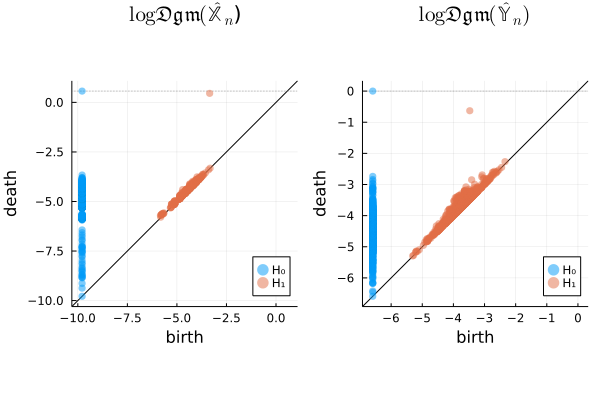

In [55]:
logDx = Dx |> rdpg.log_transform_diagram
logDy = Dy |> rdpg.log_transform_diagram
plt = plot(
    plot(logDx, title = L"$\log\mathfrak{Dgm}(\widehat{\mathbb{X}}_n$)"), 
    plot(logDy, title = L"$\log\mathfrak{Dgm}(\widehat{\mathbb{Y}}_n)$")
);
plt

### Privacy-adjusted spectral embedding
-------------------

From Eq.(1), we can use the privacy-adjusted spectral embedding 
$$
\breve{\mathbb{X}}_n = \mathsf{spectral}(\mathcal{M}_\epsilon^{\star}(A))
$$ 
for accurate topological inference. 

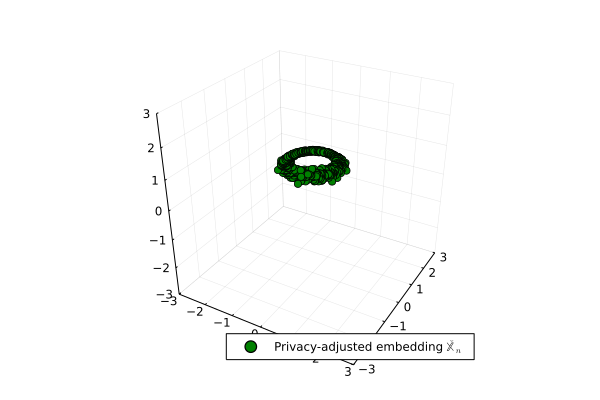

In [63]:
C = (B .- (rdpg.τ(ϵ))) ./ (rdpg.σ(ϵ))
Xc, _ = rdpg.spectralEmbed(C, d = 3, scale = false)
plt3 = @pipe Xc |> rdpg._Matrix_to_ArrayOfTuples |>
             scatter(_, c = :green, ratio = 1, lim = (-3, 3), label = "Privacy-adjusted embedding " * L"$\breve{\mathbb{X}}_n$", legend=:bottomright)

The persistence diagram $\mathfrak{Dgm}(\breve{\mathbb{X}}_n)$ is shown below.

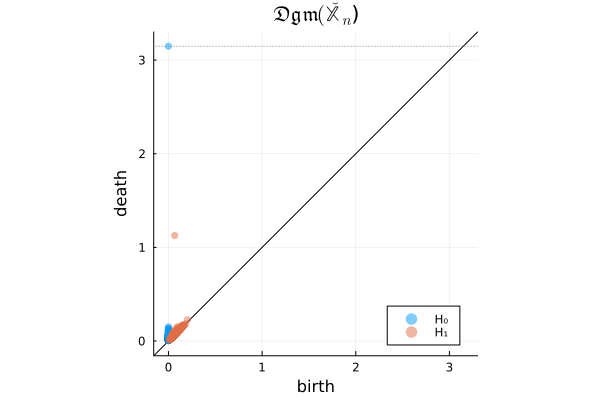

In [64]:
Dxc = @pipe Xc |> rdpg._Matrix_to_ArrayOfTuples |> ripserer(Alpha(_), dim_max=1)
plt = plot(Dxc, title=L"$\mathfrak{Dgm}(\breve{\mathbb{X}}_n$)")
plt

### Summary
----

Spectral embeddings:

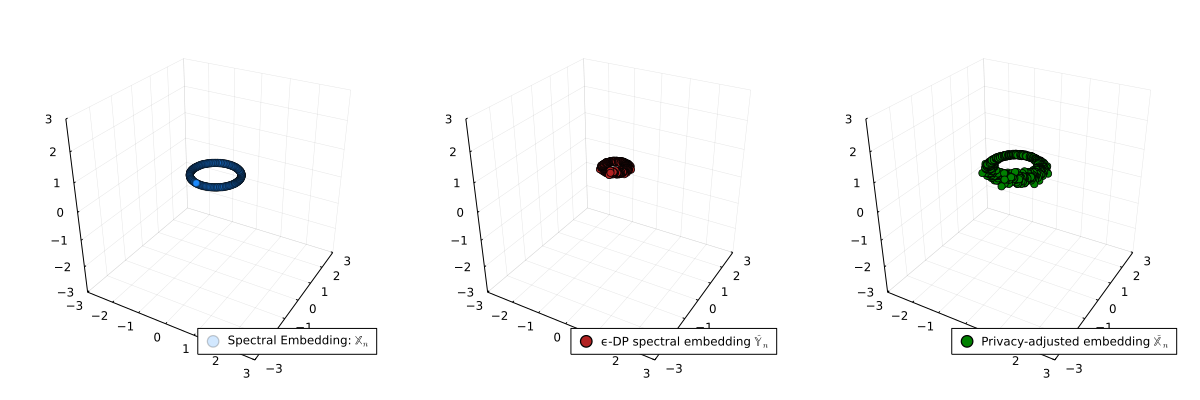

In [65]:
plot(plt1, plt2, plt3, layout=(1,3), size=(1200,400))

Persistence diagrams:

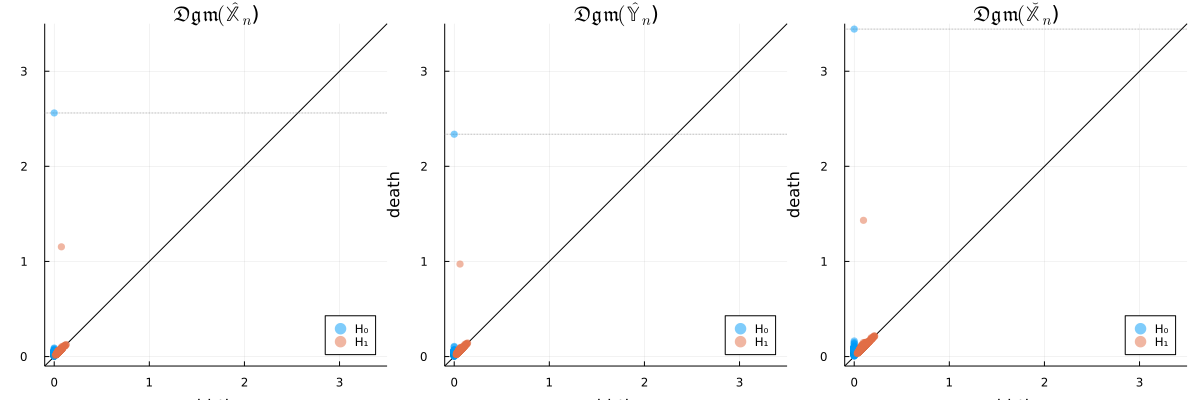

In [150]:
plt = plot(
        plot( Dx  , lim=(-0.1, 3.5), ratio=1, title=L"$\mathfrak{Dgm}(\widehat{\mathbb{X}}_n$)"),
        plot( Dy  , lim=(-0.1, 3.5), ratio=1, title=L"$\mathfrak{Dgm}(\widehat{\mathbb{Y}}_n$)"),
        plot( Dxc , lim=(-0.1, 3.5), ratio=1, title=L"$\mathfrak{Dgm}(\breve{\mathbb{X}}_n$)"), 
        layout=(1,3), size=(1200,400)
);
plt